# Airfoil experiments
All data is available in the repository

In [1]:
import sys
sys.path.append('../python')

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

from machine_learning import *
from notebook_network_size import find_best_network_size_notebook, try_best_network_sizes
from train_single_network import train_single_network
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


# Setup

In [2]:
qmc_points = np.loadtxt('../sobol_6_8000.txt')
qmc_points = qmc_points[1:].reshape((8000,6))

large_qmc_points = np.loadtxt('../sobol_6_131072.txt')
all_points = qmc_points.copy()
forces = np.array(np.loadtxt('../force_6_params.dat'))


N = min(qmc_points.shape[0], forces.shape[0])
qmc_points = qmc_points[:N,:]
forces  = forces[:N,:]


input_size=6
train_size=128
validation_size=128

epochs = 500000

airfoils_network = [12, 12, 10, 12, 10, 12, 10, 10, 12,1]


# Network sizes

Find the optimal network size


Config 4 x 6 ([0 x 0] / [2 x 2])
Training and postprocessing took: 8.291775465011597 seconds (0.13819625775019329 minutes) (0.0023032709625032213 hours)
Config 4 x 12 ([0 x 1] / [2 x 2])
Training and postprocessing took: 15.757372379302979 seconds (0.262622872988383 minutes) (0.004377047883139717 hours)
Config 8 x 6 ([1 x 0] / [2 x 2])
Training and postprocessing took: 23.152290105819702 seconds (0.3858715017636617 minutes) (0.006431191696061028 hours)
Config 8 x 12 ([1 x 1] / [2 x 2])
Training and postprocessing took: 29.835681438446045 seconds (0.4972613573074341 minutes) (0.008287689288457235 hours)
all_errors_map[Prediction error]=\ 
[[0.30448939 0.17655501]
 [0.35354953 0.18241417]]


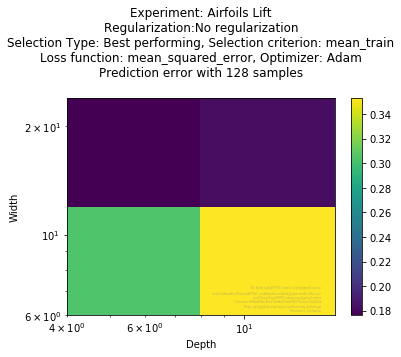

Memory usage: 740296
all_errors_map[Error mean]=\ 
[[0.12284335 0.00761549]
 [0.23032357 0.08835929]]


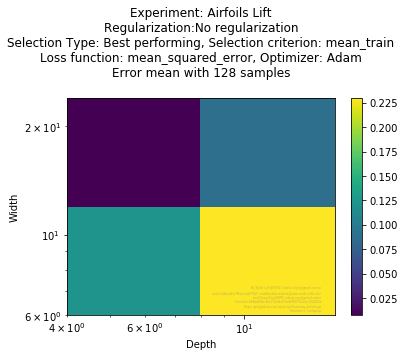

Memory usage: 741264
all_errors_map[Error variance]=\ 
[[0.19382576 0.47228551]
 [0.7916694  0.75244941]]


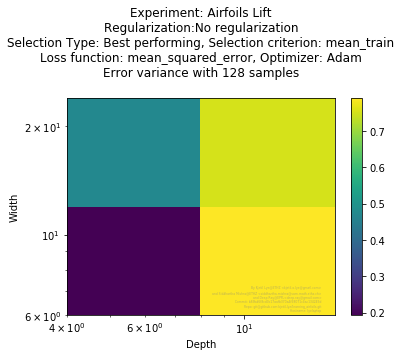

Memory usage: 741264
all_errors_map[Wasserstein]=\ 
[[0.09939159 0.04425538]
 [0.1785205  0.09194973]]


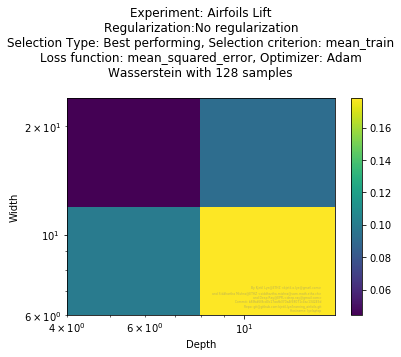

Memory usage: 741264
all_errors_map[Selection error (mean_train)]=\ 
[[11.69990093  0.91165353]
 [21.30175837  7.80309908]]


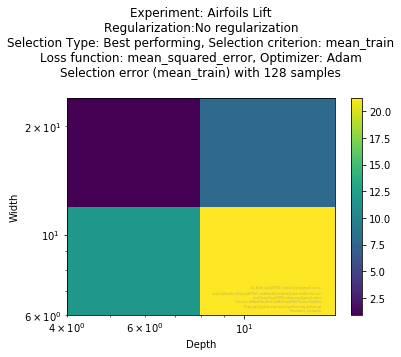

Memory usage: 741264


Config 4 x 6 ([0 x 0] / [2 x 2])


KeyboardInterrupt: 

In [3]:
force_names=['Lift', 'Drag']

for n, force_name in enumerate(force_names):
    display(HTML("<h1>%s</h1>"% force_name))
    try_best_network_sizes(parameters=qmc_points, 
                           samples=forces[:,n+1], 
                           base_title='Airfoils %s' % force_name,
                          epochs=epochs)

# One network per variable


Training took 1.3670203685760498 seconds


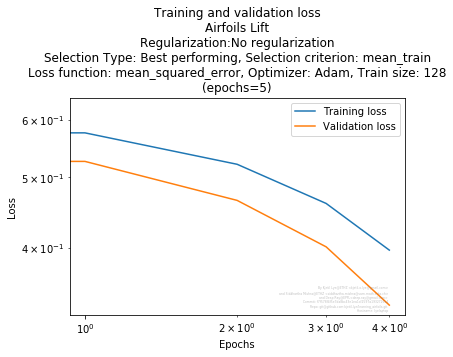


Training took 2.6222002506256104 seconds


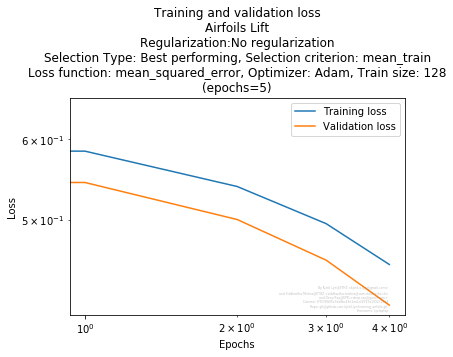


Training took 1.3090531826019287 seconds


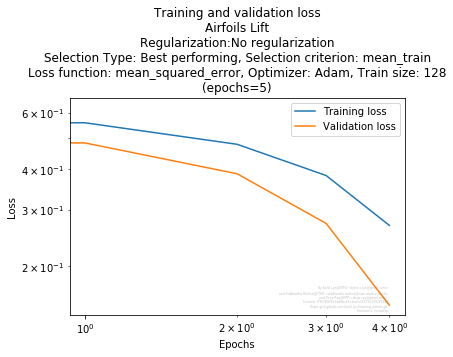


Training took 1.4047229290008545 seconds


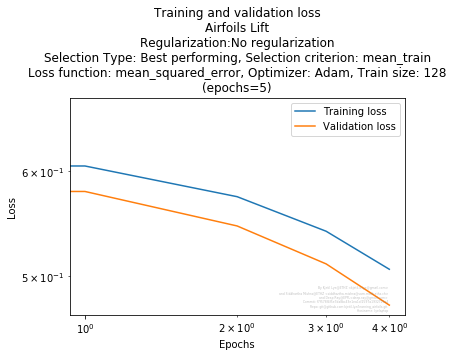


Training took 1.477271556854248 seconds


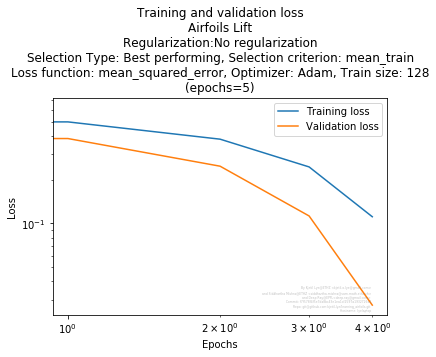

Best network index: 4
Total learning time took: 65 s


#############################################################################################
#AirfoilsLift_Noregularization_Bestperforming_mean_train_mean_squared_error_Adam_128_network#
#############################################################################################
-----  ----  ----------
Layer  Size  Parameters
0      12    84
1      12    156
2      10    130
3      12    132
4      10    130
5      12    132
6      10    130
7      10    110
8      12    132
9      1     13
Sum          1149
-----  ----  ----------
#############################################################################################


Training took 13.633664608001709 seconds


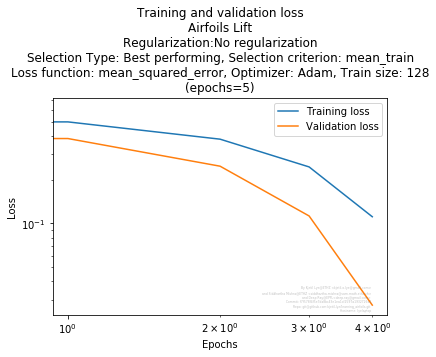

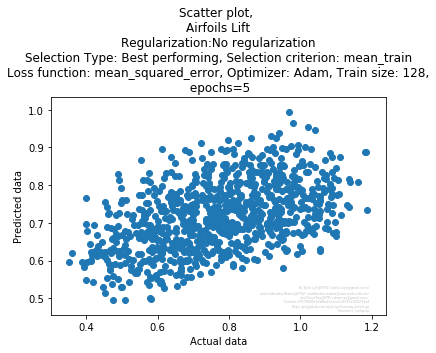

Number of parameters: 1149


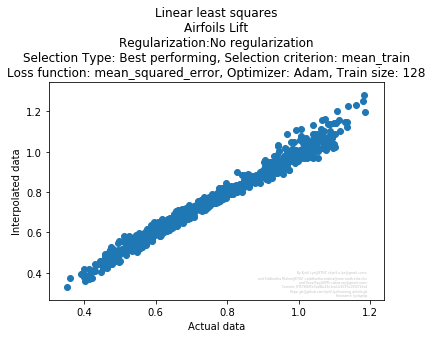

(1001,)
(1001, 6)


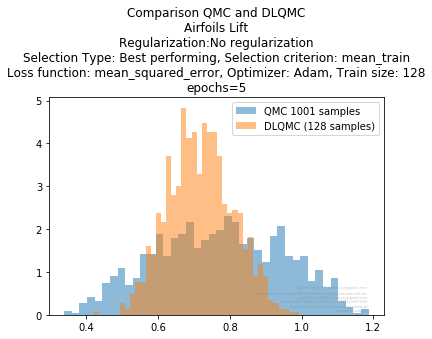

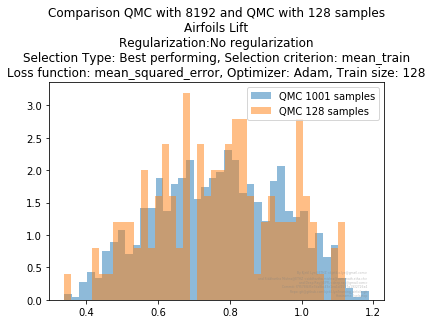

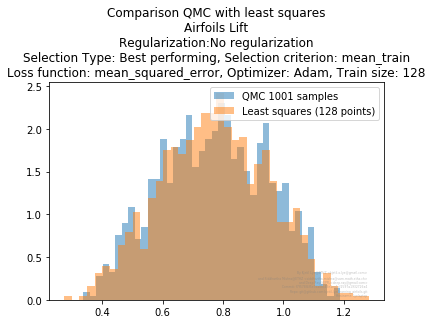

Computing large integration points


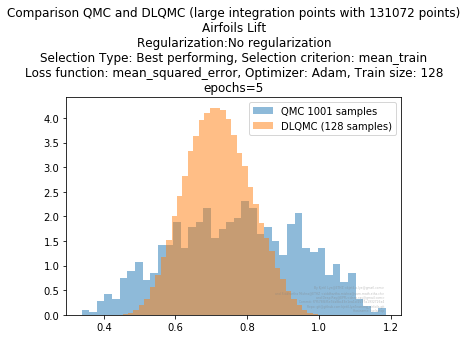

Memory usage: 459228
Memory usage: 459228


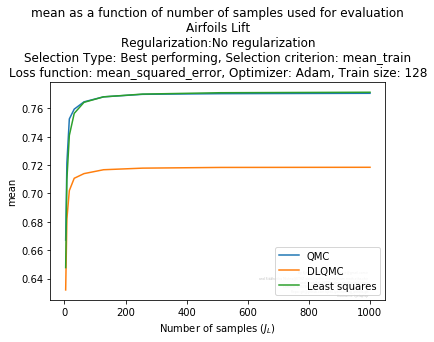

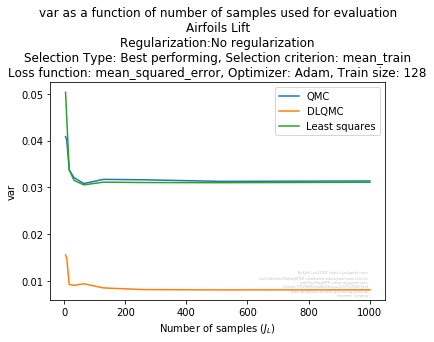

Memory usage: 459228


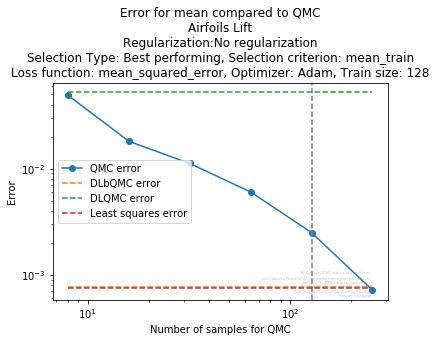

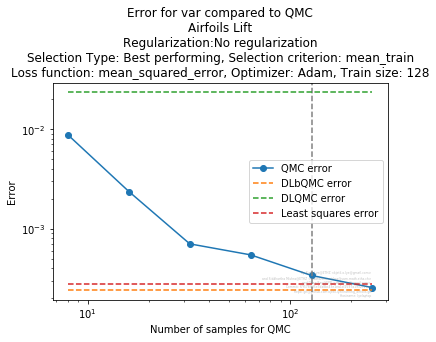

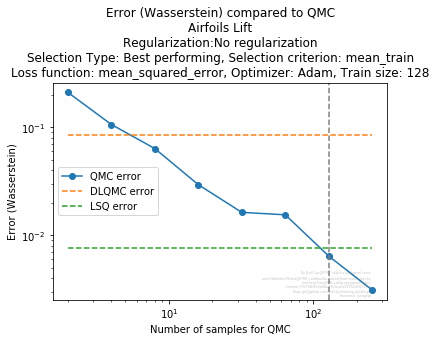

Trying with a large number of QMC samples 131072


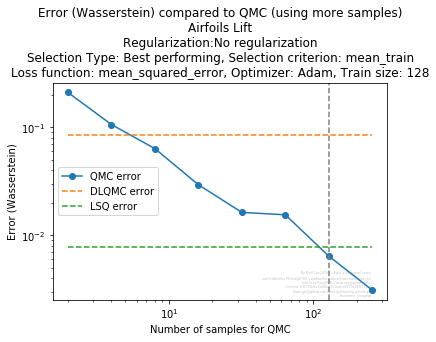

{"main_error": 0.06766527397370037, "variance_error": 0.742990265768091, "wasserstein_error": 0.08537864251536156, "selection_error": 6.223917306613123, "prediction_error": 0.22318448270040048}


###################################################################################################
#AirfoilsLift_Noregularization_Bestperforming_mean_train_mean_squared_error_Adam_128_speedup_table#
###################################################################################################
  -------  -------  -------------------  --------------------  ------------------  ------------------  -----------------  ------------------
  QMC 128  QMC 128  DLQMC                DLQMC                 DLbQMC              DLbQMC              Least squares      Least squares
  mean     var      mean                 var                   mean                var                 mean               var
Airfoils Lift
Regularization:No regularization
Selection Type: Best performing, Selection criterion: 


Training took 4.44558572769165 seconds


KeyboardInterrupt: 

In [3]:
force_names=['Lift', 'Drag']

for n, force_name in enumerate(force_names):
    display(HTML("<h1>%s</h1>"% force_name))
    train_single_network(parameters=qmc_points, 
                         samples=forces[:,n+1], 
                         base_title='Airfoils %s' % force_name,
                         network = airfoils_network,
                         epochs=epochs, 
                         large_integration_points = large_qmc_points)